In [1]:

# import requests

# url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'

# r = requests.get(url, allow_redirects=True)
# open('train_32x32.mat', 'wb').write(r.content)

In [2]:
# !du -h train_32x32.mat

In [3]:
# url2 = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'

# s = requests.get(url2, allow_redirects=True)
# open('test_32x32.mat', 'wb').write(s.content)

In [4]:
# !du -h test_32x32.mat

In [1]:
import scipy.io
train = scipy.io.loadmat('train_32x32.mat')
type(train)

dict

In [6]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [7]:
train['y'] #dtype uint8

array([[1],
       [9],
       [2],
       ...,
       [1],
       [6],
       [9]], dtype=uint8)

In [8]:
train['y']=train['y'].astype('int64')
# train['X']=train['X'].astype('float32')

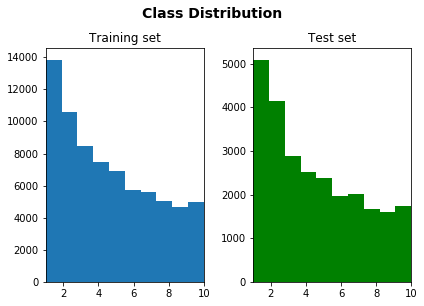

In [3]:
import scipy.io
from matplotlib import pyplot as plt

test = scipy.io.loadmat('test_32x32.mat')
type(test)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(train['y'], bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(test['y'], color='g', bins=10)
ax2.set_title("Test set")

fig.tight_layout()

In [9]:
train['y'].shape

(73257, 1)

In [10]:
import numpy as np
np.unique(train['y'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [11]:
train['X'].shape

(32, 32, 3, 73257)

In [12]:
train['X'][:,:,:,0].shape

(32, 32, 3)

In [13]:
type(train['X']) 

numpy.ndarray

In [ ]:
# !conda install shapely
# !pip install imgaug
# from imgaug import augmenters as iaa
# import imgaug as ia

In [ ]:
# class ImgAugTransform:
    
#     def __init__(self):        
#         self.aug = iaa.Sequential([
#             iaa.Sometimes(0.01, iaa.GaussianBlur(sigma=(0, 1.0))),
#             iaa.Fliplr(0.1),
#             iaa.Affine(rotate=(-1, 1), mode='symmetric'),
#             iaa.Sometimes(0.05,
#                           iaa.OneOf([iaa.Dropout(p=(0, 0.01)),
#                                      iaa.CoarseDropout(0.01, size_percent=0.5)])),
#             iaa.AddToHueAndSaturation(value=(-1, 1), per_channel=True)
#         ])

#     def __call__(self, img):
#         img = np.array(img)
#         return self.aug.augment_image(img)

# # ImgAugTransform(),

In [ ]:
import scipy.io
test = scipy.io.loadmat('test_32x32.mat')
type(test)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(train['y'], bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(test['y'], color='g', bins=10)
ax2.set_title("Test set")

fig.tight_layout()

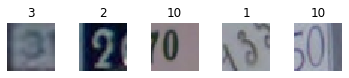

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

signs = [150, 700, 1100, 1500,5000]

for i in range(len(signs)):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    #plt.imshow(images27[traffic_signs[i]], cmap="gray")
    plt.imshow(train['X'][:,:,:,signs[i]])
    plt.subplots_adjust(wspace=0.5)
    plt.title(str(train['y'][signs[i]][0]))

    
# Show the plot
plt.show()
#10 label is 0 number 

In [15]:
import time
start_time = time.time()
print('Start time in seconds is : {}'.format(start_time))

Start time in seconds is : 1567160617.8632588


In [16]:
# import scipy.io
# test = scipy.io.loadmat('test_32x32.mat')
type(test)

dict

In [17]:
test['y']=test['y'].astype('int64')


In [18]:
train['X'].shape

(32, 32, 3, 73257)

In [19]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, utils, transforms, models
from torch.utils.data import Dataset, DataLoader
torch.from_numpy(train['X']).shape[3]

73257

In [20]:

class MyDataset(Dataset):
    def __init__(self, mat_file, transforms=None):

        self.images = mat_file['X']
        self.targets = mat_file['y']
        self.transforms = transforms


    def __getitem__(self, index):
        x = self.images[:,:,:,index]
#         x=np.moveaxis(x, -1, 0)
        y = self.targets[index][0]-1
        if self.transforms is not None:
            x = self.transforms(x)
        
        return x, y

    def __len__(self):
        return (self.images).shape[3]

In [21]:
t = transforms.Compose(
    [transforms.ToPILImage(),transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

#transforms.Grayscale(num_output_channels=1),

In [22]:
transformed_dataset = MyDataset(mat_file=train,transforms=t)
test_dataset = MyDataset(mat_file=test,transforms=t)



In [23]:
len(transformed_dataset)

73257

In [24]:
for data,label in transformed_dataset:
  print(data.shape,label.shape)
  print(data.dtype,label.dtype)

  
  break

torch.Size([3, 32, 32]) ()
torch.float32 int64


In [ ]:

# train_idx, val_idx = torch.utils.data.random_split(transformed_dataset, [train_size, test_size])
# train_loader= DataLoader(train_idx, batch_size=bsz,num_workers=nw)
# val_loader=DataLoader(val_idx, batch_size=bsz,num_workers=nw)


# test_loader= DataLoader(test_dataset, batch_size=bsz,num_workers=nw)

In [25]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

## create training and validation split 
split = int(0.8 * len(transformed_dataset))
index_list = list(range(len(transformed_dataset)))
train_idx, valid_idx = index_list[:split], index_list[split:]

In [26]:
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [27]:
## create iterator objects for train and valid datasets
# trainloader = DataLoader(transformed_dataset, batch_size=32, sampler=tr_sampler)
nw=0
bsz=64
lr=0.001
ep=11

train_loader= DataLoader(transformed_dataset, batch_size=bsz, sampler=tr_sampler,num_workers=nw)

val_loader = DataLoader(transformed_dataset, batch_size=bsz, sampler=val_sampler,num_workers=nw)
test_loader= DataLoader(test_dataset, batch_size=bsz,num_workers=nw)


In [28]:
test_loader= DataLoader(test_dataset, batch_size=bsz,num_workers=nw)
for images,labels in test_loader:
    print(images.dtype)
    print(labels.dtype)
    break

torch.float32
torch.int64


In [29]:
seed = 32
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    # Make CuDNN Determinist
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(seed)

# Define default device, cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [30]:
#i-w+*2(p)/stride

32-3+1+2
16*8*3

384

In [ ]:
#         self.conv1_bn = nn.BatchNorm2d(16)
#         x = self.dropout(self.conv1_bn(x))
#         self.dropout = nn.Dropout(0.2)


In [31]:
class Net(nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(Net, self).__init__()
        
        ## define the layers
        #conv in channel out channel kernel padding stride
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        #same padding --size with kernel 3 and padding 1
        self.dropout = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 1024) ## reshaping 
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x


model = Net()

In [32]:
!pip install torchsummary
from torchsummary import summary

summary(model.to(device), (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
           Dropout-5             [-1, 32, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]          18,496
         MaxPool2d-7             [-1, 64, 4, 4]               0
            Linear-8                  [-1, 512]         524,800
            Linear-9                   [-1, 10]           5,130
Total params: 553,514
Trainable params: 553,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 2.11
Estimated Total Size (MB): 2.42
-------------------------------------------

In [33]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=lr):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [34]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "svhn.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10 #prints every batches specified
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with torch.no_grad():
            
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                  # Forward pass
                predictions = net(inputs)
                val_loss = criterion(predictions, labels)
                total_val_loss += val_loss.item()

        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model dictionary parameters
    model.load_state_dict(torch.load(best_model_path))
    
    
    return train_history, val_history

In [35]:
model = Net()

train_history, val_history = train(model, batch_size=bsz, n_epochs=ep, learning_rate=lr)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 11
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.26 took: 2.49s
Epoch 1, 20% 	 train_loss: 2.09 took: 2.51s
Epoch 1, 30% 	 train_loss: 1.28 took: 2.49s
Epoch 1, 40% 	 train_loss: 0.94 took: 2.34s
Epoch 1, 50% 	 train_loss: 0.75 took: 2.25s
Epoch 1, 60% 	 train_loss: 0.71 took: 2.20s
Epoch 1, 70% 	 train_loss: 0.64 took: 2.32s
Epoch 1, 80% 	 train_loss: 0.62 took: 2.41s
Epoch 1, 90% 	 train_loss: 0.56 took: 2.28s
Validation loss = 0.52
Epoch 2, 10% 	 train_loss: 0.50 took: 2.24s
Epoch 2, 20% 	 train_loss: 0.49 took: 2.24s
Epoch 2, 30% 	 train_loss: 0.50 took: 2.30s
Epoch 2, 40% 	 train_loss: 0.46 took: 2.34s
Epoch 2, 50% 	 train_loss: 0.48 took: 2.31s
Epoch 2, 60% 	 train_loss: 0.45 took: 2.27s
Epoch 2, 70% 	 train_loss: 0.44 took: 2.34s
Epoch 2, 80% 	 train_loss: 0.44 took: 2.26s
Epoch 2, 90% 	 train_loss: 0.41 took: 2.27s
Validation loss = 0.46
Epoch 3, 10% 	 train_loss: 0.39 took: 2.28s
Epoch 3, 20% 	 train_loss: 0.39 took: 2.2

In [36]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()


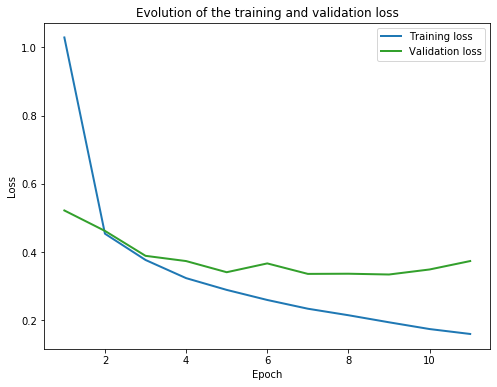

In [37]:

plot_losses(train_history, val_history)

Ground truth:

         4          1          0          9


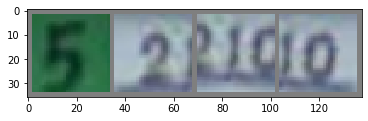

In [38]:
from torchvision.utils import make_grid
# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

try:
    images, labels = next(iter(test_loader))
except EOFError:
    pass

# print images
imshow(make_grid(images[0:4]))
print("Ground truth:\n")

print(' '.join('{:>10}'.format(labels[j]) for j in range(4)))

In [39]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(model):
    dataset_accuracy(model, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(model, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(model, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(model)

Computing accuracy...
Accuracy of the network on the 58605 train images: 95.13 %
Accuracy of the network on the 14652 validation images: 90.44 %
Accuracy of the network on the 26032 test images: 90.29 %


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(10):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(labels[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(model)

Class      Accuracy (%)
5            91.74   
1            92.94   
2            85.30   
1            93.63   
3            88.22   
5            83.44   
5            89.31   
5            88.55   
0            89.11   
1            90.59   


In [42]:

classes = ('1', '2', '3', '4',
           '5', '6', '7', '8', '9', '0')

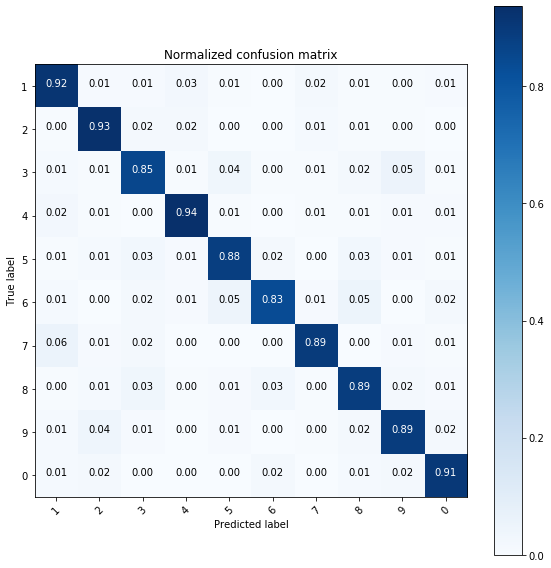

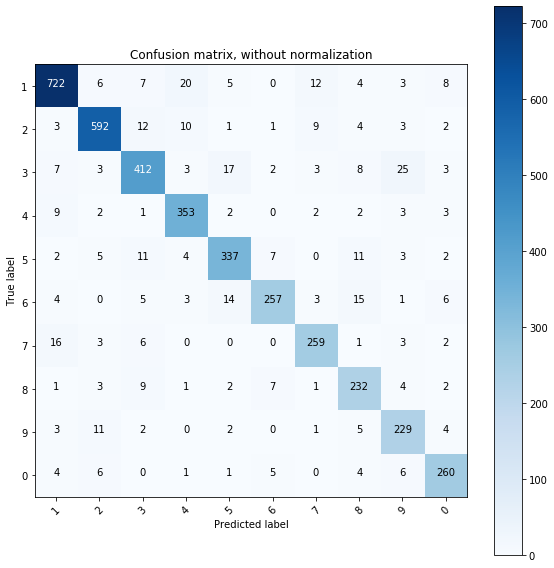

In [43]:
import itertools

# Plot normalized confusion matrix 
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')